# Unsupervised Learning
## Chapter X: Principal Component Analysis
Yen Lee Loh, 2022-11-25

---
## 0. Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import torch
from torch import nn
import torchvision.datasets # In functional.py: patch PILLOW_VERSION--> __version__
import torchvision.transforms
import pandas as pd    # for DataFrame
import time
import IPython.display
rng = np.random.default_rng()

---
## 1. PCA for 2D distributions
Generate a set of points from a bivariate Gaussian distribution:

In [2]:
def gaussianCloud (numPoints, centerVector, shapeMatrix):
  return rng.standard_normal ([numPoints,len(centerVector)]).dot(shapeMatrix) + centerVector
xnd = gaussianCloud(1000, [1,-2], [[3,0],[0,2]])

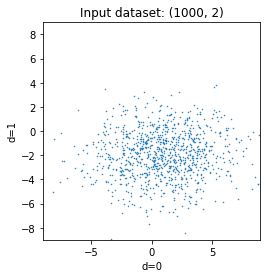

In [3]:
plt.plot (xnd[:,0], xnd[:,1], '.',markersize=1)
plt.xlabel ('d=0'); plt.ylabel ('d=1'); plt.title ('Input dataset: {}'.format(xnd.shape))
plt.xlim ([-9,9]); plt.ylim ([-9,9]); plt.gca().set_aspect ('equal')

Shift the data points with respect to the center or mass: $u_{nd} = x_{nd} - x^\text{mean}_{d}$.
Compute the covariance matrix, $C_{dd'} = \sum_{n} u_{nd} u_{nd'} = ({\bf u}^T \cdot {\bf u})_{dd'}$, which is a real symmetric matrix.
Diagonalize it to find its eigenvalues $w_m$ and eigenvectors $v_{dm}$.
Use the eigenvector matrix to transform the set of input vectors $x_{nd}$ into a set of feature vectors $f_{nm} = \sum_{n} u_{nd} v_{dm}$, where $m$ runs over the set of features:

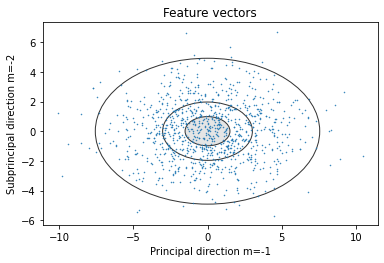

In [4]:
#======== SHIFT THE INPUT VECTORS (WITHOUT NORMALIZING)
und = xnd - np.mean(xnd,axis=0)
#und = und/np.std(und,axis=0)
#======== CALCULATE COVARIANCE MATRIX AND FIND TWO MOST IMPORTANT EIGENVECTORS
Cdd = und.T.dot(und) / und.shape[0]
wm,vdm = np.linalg.eigh (Cdd)
fnm = und.dot(vdm[:,[-1,-2]])
#======== VISUALIZE SCATTER IN FEATURE SPACE
plt.plot (fnm[:,0], fnm[:,1], '.',markersize=1)
plt.xlabel ('Principal direction m=-1'); plt.ylabel ('Subprincipal direction m=-2'); plt.title ('Feature vectors')
plt.gca().set_aspect ('equal')
rm = np.sqrt(wm) # semiaxes of 1-sigma ellipse
plt.gca().add_patch (Ellipse((0,0), rm[-1], rm[-2], edgecolor='#333', facecolor=(0,0,0,0.1)));
plt.gca().add_patch (Ellipse((0,0), 2*rm[-1], 2*rm[-2], edgecolor='#333', facecolor=(0,0,0,0)));
plt.gca().add_patch (Ellipse((0,0), 5*rm[-1], 5*rm[-2], edgecolor='#333', facecolor=(0,0,0,0)));

The plot above shows the data in **feature space**.  The ellipses are the $1\sigma$, $2\sigma$, and $5\sigma$ ellipses.

Repeat the exercise for a more complicated (bimodal) distribution:
(Recall: mean, mode, median.)

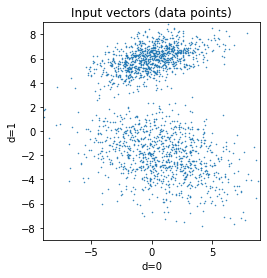

In [5]:
xnd = np.vstack ([
  gaussianCloud(1000, [0,6], [[2,0],[1,1]]),
  gaussianCloud(1000, [1,-2], [[3,0],[-1,2]]),
])
plt.plot (xnd[:,0], xnd[:,1], '.',markersize=1)
plt.xlabel ('d=0'); plt.ylabel ('d=1'); plt.title ('Input vectors (data points)')
plt.xlim ([-9,9]); plt.ylim ([-9,9]); plt.gca().set_aspect ('equal')

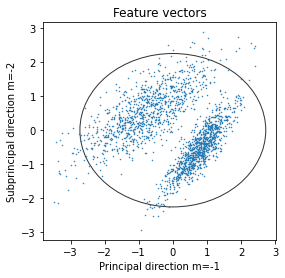

In [6]:
#======== SHIFT AND NORMALIZE THE INPUT VECTORS
und = xnd - np.mean(xnd,axis=0)
und = und/np.std(und,axis=0)
#======== CALCULATE COVARIANCE MATRIX AND FIND TWO MOST IMPORTANT EIGENVECTORS
Cdd = und.T.dot(und) / und.shape[0]
wm,vdm = np.linalg.eigh (Cdd)
fnm = und.dot(vdm[:,[-1,-2]])
#======== VISUALIZE SCATTER IN FEATURE SPACE
plt.plot (fnm[:,0], fnm[:,1], '.',markersize=1)
plt.xlabel ('Principal direction m=-1'); plt.ylabel ('Subprincipal direction m=-2'); plt.title ('Feature vectors')
plt.gca().set_aspect ('equal')
rm = np.sqrt(wm) # semiaxes of 1-sigma ellipse
plt.gca().add_patch (Ellipse((0,0), 5*rm[-1], 5*rm[-2], edgecolor='#333', facecolor=(0,0,0,0)));

The plot above shows the data in **feature space**.  The data set has the greatest variance in the principal direction $m=-1$, corresponding to the principal axis, which is the semimajor axis of the ellipse.  We might hope that the two parts of the datasets are separated in this direction.  (This didn't work too well.)

---
## 2. PCA for 3D distributions
Now consider a 3D distribution:

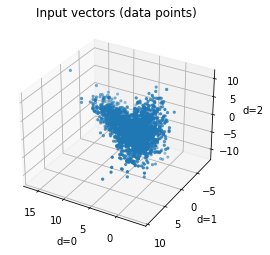

In [7]:
xnd = np.vstack ([
  gaussianCloud(1000, [1,2,2], [[1,0,-2],[0,2,-1],[1,0,2]]),
  gaussianCloud(1000, [7,-2,-2], [[1,0,2],[0,2,1],[2,0,2]]),
])
fig = plt.figure(); ax = fig.add_subplot (projection='3d', elev=30,azim=120)
ax.scatter (xnd[:,0], xnd[:,1], xnd[:,2], marker='.')
plt.xlabel ('d=0')
plt.ylabel ('d=1')
ax.set_zlabel('d=2')
plt.title ('Input vectors (data points)');

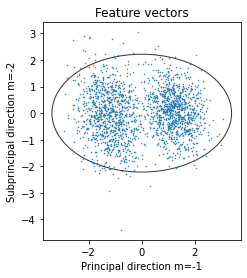

In [8]:
#======== SHIFT AND NORMALIZE THE INPUT VECTORS
und = xnd - np.mean(xnd,axis=0)
und = und/np.std(und,axis=0)
#======== CALCULATE COVARIANCE MATRIX AND FIND TWO MOST IMPORTANT EIGENVECTORS
Cdd = und.T.dot(und) / und.shape[0]
wm,vdm = np.linalg.eigh (Cdd)
fnm = und.dot(vdm[:,[-1,-2]])
#======== VISUALIZE SCATTER IN FEATURE SPACE
plt.plot (fnm[:,0], fnm[:,1], '.',markersize=1)
plt.xlabel ('Principal direction m=-1'); plt.ylabel ('Subprincipal direction m=-2'); plt.title ('Feature vectors')
plt.gca().set_aspect (1)
rm = np.sqrt(wm) # semiaxes of 1-sigma ellipse
plt.gca().add_patch (Ellipse((0,0), 5*rm[-1], 5*rm[-2], edgecolor='#333', facecolor=(0,0,0,0)));

PCA has taken the 3D data set and collapsed it to 2D.  The dataset is most spread out in the principal direction.  One might hope that PCA reveals that 

---
## 3. Set up and load the MNIST Digits dataset

In [9]:
#================ DOWNLOAD THE MNIST-TRAIN DATASET, WHICH CONTAINS 60000 HANDWRITTEN DIGITS
#================ NOTE: THE MNIST-TEST DATASET CONTAINS 10000 MORE HANDWRITTEN DIGITS
dataset = torchvision.datasets.MNIST('MNIST-TRAIN', download=True, train=True, transform=torchvision.transforms.ToTensor())
loader = torch.utils.data.DataLoader(dataset, batch_size=70000, shuffle=False)
#inputsMNISTTRAIN,outputsMNISTTRAIN = iter(loader).next()   # old PyTorch syntax; no longer works
iterator = iter(loader)
inputsMNISTTRAIN,outputsMNISTTRAIN = next(iterator)        # new PyTorch syntax
inputsMNISTTRAIN = np.squeeze(inputsMNISTTRAIN)            # eliminate unnecessary dimension of tensor
print ("inputsMNISTTRAIN.shape  =", inputsMNISTTRAIN.shape)
print ("outputsMNISTTRAIN.shape =", outputsMNISTTRAIN.shape)

inputsMNISTTRAIN.shape  = torch.Size([60000, 28, 28])
outputsMNISTTRAIN.shape = torch.Size([60000])


"1D array = vector, 2D array = matrix, 3D,4D,... array = tensor "
"tensor"s:  inertia tensor, polarizability tensor, **stress tensor**, strain tensor, elasticity tensor, metric tensor, etc.

In [10]:
60000*28*28 /1048576

44.86083984375

In [11]:
inputsMNISTTRAIN[0].type

<function Tensor.type>

In [12]:
inputsMNISTTRAIN[0].dtype

torch.float32

In [13]:
inputsMNISTTRAIN[0].shape

torch.Size([28, 28])

In [14]:
np.set_printoptions (precision=2,linewidth=200)
print (inputsMNISTTRAIN[0].numpy())

[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.07 0.07 0.07 0.49 0.53 0.69 0.1  0.65 1.   0.97 0.5  0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.12 0.14 0.37 0.6  0.67 0.99 0.99 0.99 0.99 0.99 0.88 0.67 0.99 0.95 0.76 0.25 0.   0.   0.   0.  ]

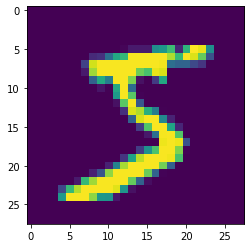

In [15]:
plt.imshow (inputsMNISTTRAIN[0])

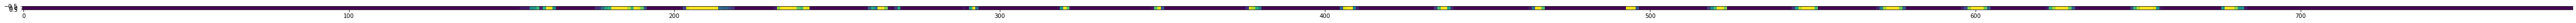

In [16]:
figure = plt.figure(figsize=(80,10))
plt.imshow (inputsMNISTTRAIN[0].reshape (1,784))

---
## 4. Select a pair of digits

In [17]:
digit0,digit1 = 3,8
indices0 = np.where(outputsMNISTTRAIN==digit0)[0]
indices1 = np.where(outputsMNISTTRAIN==digit1)[0]
print ("Number of {:}'s in MNIST-TRAIN dataset = {:}".format(digit0, indices0.size))
print ("Number of {:}'s in MNIST-TRAIN dataset = {:}".format(digit1, indices1.size))
def scramble (a): a[:]=a[rng.permutation(a.size)]
scramble (indices0)
scramble (indices1)

Number of 3's in MNIST-TRAIN dataset = 6131
Number of 8's in MNIST-TRAIN dataset = 5851


In [18]:
#================ GET TRAINING DATASET
indices = np.concatenate ([indices0[:1000], indices1[:1000]])
#scramble (indices)
inputs = inputsMNISTTRAIN[indices]
outputs = outputsMNISTTRAIN[indices]

In [19]:
#======== FLATTEN 28x28 IMAGES INTO 784-ELEMENT VECTORS
xnd = inputs.reshape (-1, 28*28) * 1.0 ; xnd = xnd.numpy()
ynd = outputs.reshape (-1, 1)    * 1.0 ; ynd -= digit0 ; ynd /= (digit1-digit0) ; ynd = ynd.numpy().round().astype(int) ; yn = ynd[:,0]
nmax,dmax = xnd.shape
print ("Input (features):     xnd.shape =",xnd.shape,"\tminmax(xnd) =", [xnd.min(),xnd.max()] )
print ("Output (predictions): ynd.shape =",ynd.shape,"\tminmax(ynd) =", [ynd.min(),ynd.max()] )

Input (features):     xnd.shape = (2000, 784) 	minmax(xnd) = [0.0, 1.0]
Output (predictions): ynd.shape = (2000, 1) 	minmax(ynd) = [0, 1]


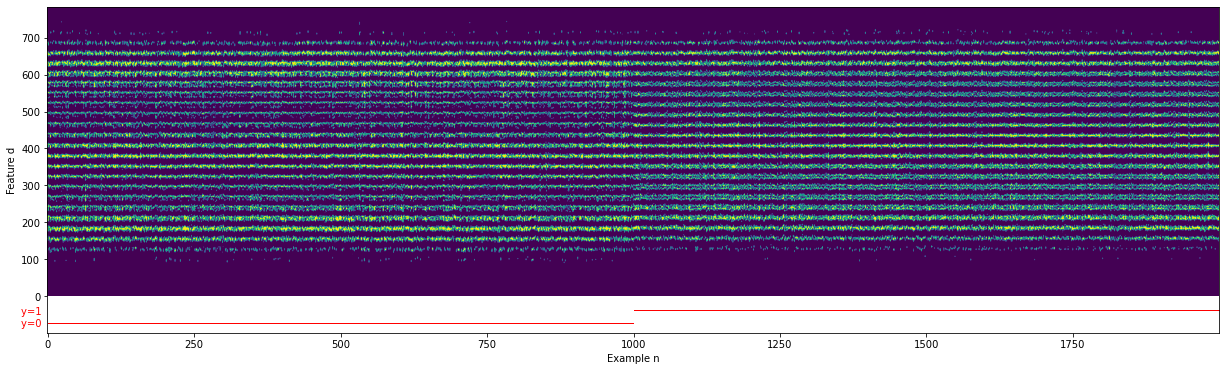

In [20]:
#======== VISUALIZE OUR ENTIRE 2000x784 TRAINING DATASET
figure = plt.figure(figsize=(21,6))
plt.imshow (xnd.T, cmap='viridis', aspect='auto'); plt.xlabel ('Example n'); plt.ylabel ('Feature d');
plt.ylim ([-99, 784]); plt.plot (-75+ynd*35,'r,');
plt.text (0,-75,'y=0  ', color='r', va='center', ha='right');
plt.text (0,-40,'y=1  ', color='r', va='center', ha='right');

The above plot shows a dataset $x_{nd}$ with 2000 instances x 768 pixels.  It is difficult for a human to tell, at first glance, which pixels help to distinguish between the two types of digits.  Perform PCA as before:

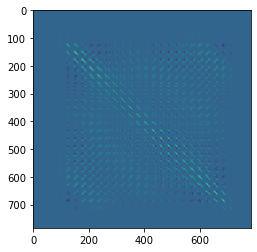

In [21]:
#======== SHIFT AND NORMALIZE THE INPUT VECTORS
und = xnd - np.mean(xnd,axis=0)
und = und/(np.std(und,axis=0)+1)
#======== CALCULATE COVARIANCE MATRIX AND FIND TWO MOST IMPORTANT EIGENVECTORS
Cdd = und.T.dot(und) / und.shape[0]
wm,vdm = np.linalg.eigh (Cdd)
fnm = und.dot(vdm[:,[-1,-2]])
#======== VISUALIZE COVARIANCE MATRIX
plt.imshow (Cdd);

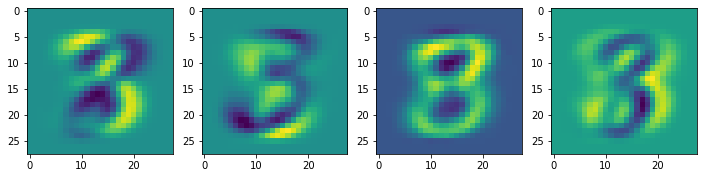

In [22]:
#================ VISUALIZE PRINCIPAL VECTORS
plt.figure(figsize=(12,3))
for n in range(1,1+4):
  plt.subplot (1,4,n); plt.imshow (vdm[:,-n].reshape (28,28))

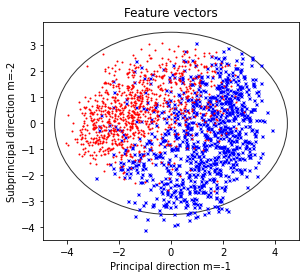

In [23]:
#================ VISUALIZE DATA IN FEATURE SPACE
wm,vdm = np.linalg.eigh (Cdd)
fnm = und.dot(vdm[:,[-1,-2]])
group0 = np.where(yn==0)[0]
group1 = np.where(yn==1)[0]
plt.plot (fnm[group0,0], fnm[group0,1], 'bx', markersize=3)
plt.plot (fnm[group1,0], fnm[group1,1], 'ro', markersize=1)
plt.xlabel ('Principal direction m=-1'); plt.ylabel ('Subprincipal direction m=-2'); plt.title ('Feature vectors')
plt.gca().set_aspect ('equal')
rm = np.sqrt(np.abs(wm)) # semiaxes of 1-sigma ellipse
plt.gca().add_patch (Ellipse((0,0), 5*rm[-1], 5*rm[-2], edgecolor='#333', facecolor=(0,0,0,0)));

We see that the two types of input vectors are fairly well separated in feature space!

---
## 5. Repeat exercise

In [48]:
def analyzeDigits (digitList=[3,8]):
  #================ FILTER MNIST DATASET FOR DIGIT PAIR
  blah = np.array ([], dtype='int')
  for digit in digitList:
    indices = np.where(outputsMNISTTRAIN==digit)[0]
    def scramble (a): a[:]=a[rng.permutation(a.size)]
    scramble (indices)
    blah = np.concatenate ([blah, indices[:1000]])
  indices = blah
  #================ GET TRAINING DATASET
  #scramble (indices)
  inputs = inputsMNISTTRAIN[indices]
  outputs = outputsMNISTTRAIN[indices]
  #======== FLATTEN 28x28 IMAGES INTO 784-ELEMENT VECTORS
  xnd = inputs.reshape (-1, 28*28) * 1.0 ; xnd = xnd.numpy()
  yn = outputs.flatten().numpy().round().astype(int)
  nmax,dmax = xnd.shape
  #======== SHIFT AND NORMALIZE THE INPUT VECTORS
  und = xnd - np.mean(xnd,axis=0)
  und = und/(np.std(und,axis=0)+1)
  #======== CALCULATE COVARIANCE MATRIX AND FIND TWO MOST IMPORTANT EIGENVECTORS
  Cdd = und.T.dot(und) / und.shape[0]
  wm,vdm = np.linalg.eigh (Cdd)
  fnm = und.dot(vdm[:,[-1,-2]])
  #================ VISUALIZE DATA IN FEATURE SPACE
  for digit in digitList:
    idx = np.where(yn==digit)[0]
    plt.plot (fnm[idx,0], fnm[idx,1], '.', markersize=2, label=digit)
  #plt.xlabel ('Principal direction m=-1'); plt.ylabel ('Subprincipal direction m=-2'); 
  plt.xlabel ('Principal component $W_{n,f=-1}$'); plt.ylabel ('Subprincipal component $W_{n,f=-2}$'); 
  plt.title ('Feature vectors'); plt.legend()
  plt.gca().set_aspect ('equal')
  rm = np.sqrt(np.abs(wm)) # semiaxes of 1-sigma ellipse
  plt.gca().add_patch (Ellipse((0,0), 5*rm[-1], 5*rm[-2], edgecolor='#333', facecolor=(0,0,0,0)));
  return wm,vdm    # should return fnm also
  # really, the PCA routine should return  basis vectors as well as feature vectors
  # i.e.,                                  (Hfd = vdm.T?             (Wnf)

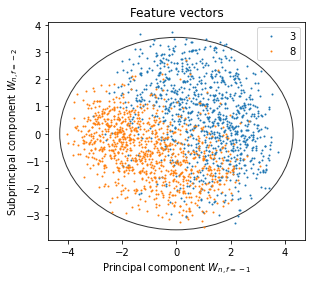

In [49]:
analyzeDigits ([3,8]);

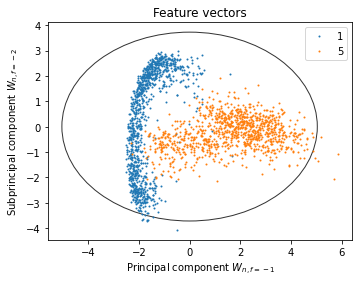

In [50]:
analyzeDigits ([1,5]);

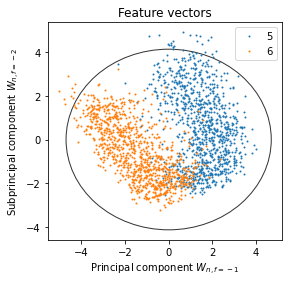

In [51]:
analyzeDigits ([5,6]);

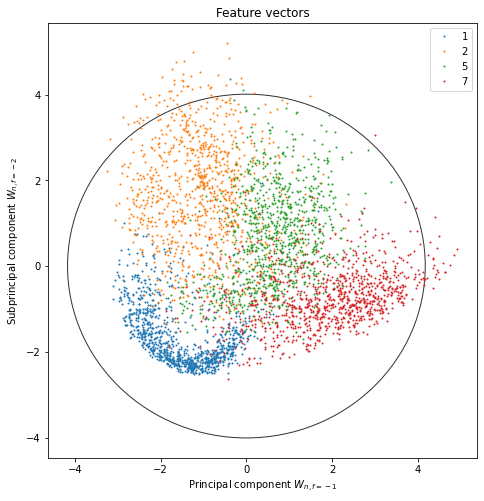

In [52]:
wm,vdm = analyzeDigits ([1,2,5,7]) ; plt.gcf().set_size_inches ([8,8])

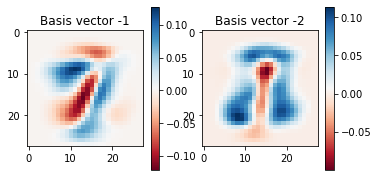

In [53]:
#================ VISUALIZE PRINCIPAL VECTORS
plt.figure(figsize=(12,3))
for n in range(1,1+2):
  plt.subplot (1,4,n); plt.imshow (vdm[:,-n].reshape (28,28), cmap='RdBu'); plt.title ('Basis vector -{}'.format(n))
  plt.colorbar();

- We have taken input vectors Xnd (where n is sample index and d=0,1,2,...,783 is the pixel index)
- and converted to feature vectors Wnf (where n is sample index and f=-1,-2 is the feature index).